## Chronos Finetuned M


In [ ]:
!pip install chronos-forecasting

In [ ]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")



Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'd_pi', 'dI_t', 'Q']

Fine-tune panel: 1980-12-10 → 1999-12-31 | n=4930
Fine-tune FX columns: ['AUD', 'CAD', 'CHF', 'DKK', 'GBP', 'ISK', 'JPY', 'NZD', 'SEK', 'USD', 'XDR']

[Fine-tuning Chronos-2 on Norges Bank FX panel 1980–1999]
  Number of series: 11
  Total length across series: 52815
  Using prediction_length=32, num_steps=50, lr=1e-05, batch_size=2


/tmp/ipython-input-3666062270.py:240: FutureWarning: Fine-tuning support is experimental and may be changed in future versions.
  pipeline = pipeline.fit(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.024800
20,2.704700
30,1.760400
40,1.748100
50,1.498000



Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – past macro covariates, finetuned) ===
Observations: 308
RMSE (level): 0.141597
MAE  (level): 0.097244
Directional accuracy: 204/307 (66.4%)

=== Diebold–Mariano vs Random Walk (past macro covariates, monthly, finetuned) ===
Loss: MSE | horizon h=1
DM-statistic: -3.1622
p-value     : 0.0016


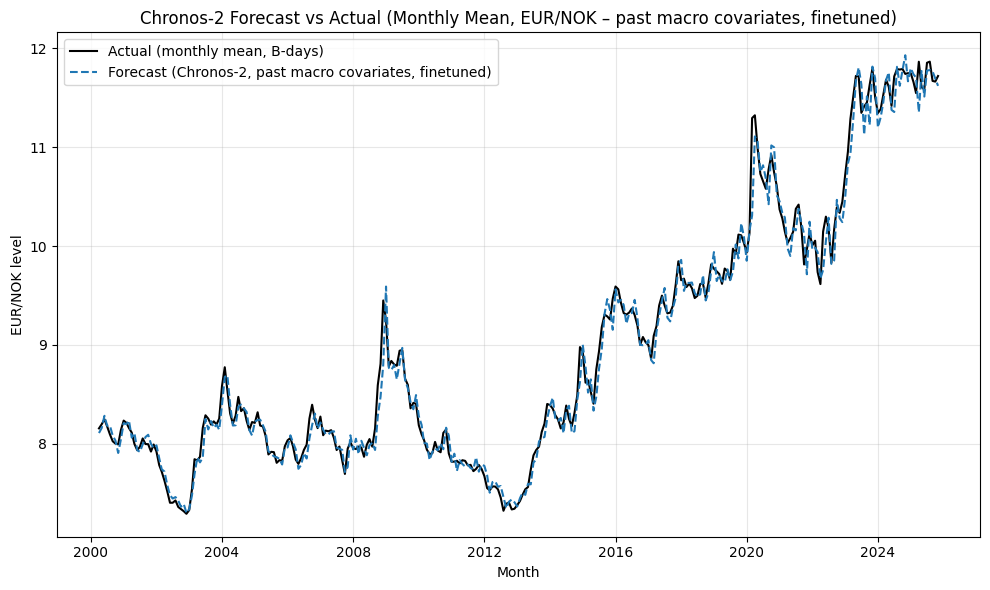

Saved: Chronos2M_daily_pastcov_finetuned.png
Saved: Chronos2M_daily_pastcov_finetuned.pdf


In [5]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (monthly, levels) with daily macro covariates
+ optional fine-tuning on Norges Bank FX panel (1980–1999).

Univariate setup for evaluation:
  - Target: EUR_NOK (single series)
  - Macros: Q, d_pi, dI_t as past-only covariates
  - Data: daily (calendar days), forward-filled
  - Cut: last business day of previous month (based on EUR_NOK B-days)
  - Forecast: next calendar month at daily frequency,
              aggregated to monthly mean over business days (EUR/NOK)
  - No future_df passed to Chronos-2 -> no leakage from future macro paths

Fine-tuning setup:
  - Dataset: Norges Bank FX panel 1980–1999 (NB1980-1999.csv)
  - Columns: ds; AUD; CAD; CHF; DKK; GBP; ISK; JPY; NZD; SEK; USD; XDR
  - Each FX series is treated as a separate univariate item.
  - No covariates in fine-tuning stage (price-only panel).
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # from chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url_daily: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    url_finetune: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
    )
    m_freq: str = "M"          # monthly evaluation
    min_hist_days: int = 40    # minimum number of daily obs before first forecast
    max_context: int = 2048
    max_horizon: int = 64      # must exceed longest month (~31 days); 64 is a safe margin
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_pastcov_finetuned.png"
    fig_pdf: str = "Chronos2M_daily_pastcov_finetuned.pdf"

    # Fine-tuning hyperparameters (conservative for limited GPU memory)
    ft_prediction_length: int = 32
    ft_num_steps: int = 50
    ft_learning_rate: float = 1e-5
    ft_batch_size: int = 2
    ft_logging_steps: int = 10

CFG = Config()

TARGET_SERIES = "EUR_NOK"
MACRO_COLS = ["Q", "d_pi", "dI_t"]

FINETUNE_FX_COLS = [
    "AUD", "CAD", "CHF", "DKK", "GBP",
    "ISK", "JPY", "NZD", "SEK", "USD", "XDR",
]

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading: daily EUR_NOK (B + D) + macro covariates
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV with columns:
      Date, EUR_NOK, Q, d_pi, dI_t

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (for cuts and monthly ground truth)
      DF_d : daily (D) DataFrame with columns [EUR_NOK, Q, d_pi, dI_t],
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", "EUR_NOK", "Q", "d_pi", "dI_t"}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", "EUR_NOK"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types for all non-date columns
    for col in ["EUR_NOK"] + MACRO_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["EUR_NOK"])

    # Business-day EUR_NOK (ground truth / aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily DF_d (calendar days, forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Load fine-tuning FX panel (1980–1999)
# -----------------------------
def load_finetune_fx_panel(url: str) -> pd.DataFrame:
    """
    Load Norges Bank 1980–1999 FX panel for fine-tuning.
    CSV format:
      ds;AUD;CAD;CHF;DKK;GBP;ISK;JPY;NZD;SEK;USD;XDR

    Returns:
      df with index=DATE (daily), columns = FINETUNE_FX_COLS (floats), sorted.
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(
        io.StringIO(text),
        sep=";",
        decimal=".",
        encoding="utf-8-sig",
    )

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in FINETUNE_FX_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df

# -----------------------------
# Chronos-2: base pipeline + fine-tuning
# -----------------------------
def build_base_chronos_pipeline() -> BaseChronosPipeline:
    """Load the base Chronos-2 pipeline on CUDA in fp16."""
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install a CUDA build of PyTorch and a recent NVIDIA driver.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )
    return pipeline

def finetune_chronos_on_nb_panel(
    pipeline: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
) -> BaseChronosPipeline:
    """
    Fine-tune Chronos-2 on the Norges Bank FX panel 1980–1999.

    Each FX column (AUD, CAD, ..., XDR) is treated as a separate univariate series.
    No covariates are used during fine-tuning; this is a pure price-only panel.
    """
    train_inputs: List[Dict] = []

    for col in FINETUNE_FX_COLS:
        series = fx_panel[col].dropna().astype(np.float32).values
        if series.size < CFG.ft_prediction_length * 2:
            continue

        train_inputs.append(
            {
                "target": series,
                "past_covariates": {},   # no past covariates in fine-tuning
                "future_covariates": {}, # no future covariates in fine-tuning
            }
        )

    if not train_inputs:
        raise RuntimeError("No valid series found for fine-tuning.")

    if CFG.verbose:
        total_len = sum(len(d["target"]) for d in train_inputs)
        print("\n[Fine-tuning Chronos-2 on Norges Bank FX panel 1980–1999]")
        print(f"  Number of series: {len(train_inputs)}")
        print(f"  Total length across series: {total_len}")
        print(
            f"  Using prediction_length={CFG.ft_prediction_length}, "
            f"num_steps={CFG.ft_num_steps}, lr={CFG.ft_learning_rate}, "
            f"batch_size={CFG.ft_batch_size}"
        )

    pipeline = pipeline.fit(
        inputs=train_inputs,
        prediction_length=CFG.ft_prediction_length,
        num_steps=CFG.ft_num_steps,
        learning_rate=CFG.ft_learning_rate,
        batch_size=CFG.ft_batch_size,
        logging_steps=CFG.ft_logging_steps,
    )

    return pipeline

# -----------------------------
# Chronos-2 model builder (univariate + past-only macro covariates)
# -----------------------------
def build_model_chronos2(
    pipeline: BaseChronosPipeline,
    max_context: int,
    horizon_len: int,
) -> Callable[[pd.DataFrame, int], np.ndarray]:
    """
    Build a Chronos-2 forecasting function for a single EUR_NOK series with past-only macro covariates.

    Uses a pre-loaded (and potentially fine-tuned) Chronos-2 pipeline.

    Returns:
      forecast_fn(hist_df, H) -> np.ndarray length H (daily point forecasts)

    hist_df:
      index  : DATE (daily, up to and including cut)
      columns: [EUR_NOK, Q, d_pi, dI_t]
    """

    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        """Extract median forecast from Chronos output."""
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            y = df["0.5"].to_numpy()
        elif "predictions" in df.columns:
            y = df["predictions"].to_numpy()
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            y = df["forecast"].to_numpy()
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    y = df[cand].to_numpy()
                    break
            else:
                raise RuntimeError(f"Chronos2 predict_df: unsupported schema. Columns={list(df.columns)}.")

        return np.asarray(y, dtype=float)

    def _forecast(hist_df: pd.DataFrame, H: int) -> np.ndarray:
        """
        Run Chronos-2 on the EUR_NOK series with macro covariates using only past information.

        Input:
          hist_df: DF_d.loc[:cut], daily, columns [EUR_NOK, Q, d_pi, dI_t]

        Output:
          np.ndarray with H daily forecasts for EUR_NOK.
        """
        ctx = hist_df.tail(max_context).copy()

        df_ctx = ctx.reset_index().rename(columns={"DATE": "timestamp", "EUR_NOK": "target"})
        df_ctx["item_id"] = "EUR_NOK"

        cols = ["item_id", "timestamp", "target"] + MACRO_COLS
        df_ctx = df_ctx[cols]

        with torch.inference_mode():
            pred = pipeline.predict_df(
                df_ctx,
                prediction_length=H,
                quantile_levels=[0.5],  # median only
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                # No future_df passed -> macros are interpreted as past covariates only
            )

        med = _extract_median(pred)
        return med[:H]

    return _forecast

# -----------------------------
# Monthly walk-forward with past macro covariates
# -----------------------------
def walk_forward_chronos2_monthly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], np.ndarray],
) -> pd.DataFrame:
    """
    Monthly walk-forward evaluation based on daily EUR_NOK forecasts with macro covariates.

    For each calendar month m:
      - Cut at last business day of previous month (based on EUR_NOK series S_b).
      - Use all daily observations up to and including cut (DF_d) as history:
          EUR_NOK as target, Q, d_pi, dI_t as past covariates.
      - Forecast the full next calendar month at daily frequency.
      - Aggregate EUR_NOK forecasts to the monthly mean over business days.
      - Compare to the actual EUR_NOK monthly mean from S_b.
    """
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        pf = forecast_fn(hist_df, H)
        if pf.shape[0] < H:
            dropped[str(m)] = f"horizon_short({pf.shape[0]})"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in df.index]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")
    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – past macro covariates, finetuned) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse",
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple Newey–West/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """Random walk benchmark: previous month's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (past macro covariates, monthly, finetuned) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value: nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (monthly mean, EUR/NOK)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(
        x,
        eval_df["y_pred"],
        color="tab:blue",
        linestyle="--",
        label="Forecast (Chronos-2, past macro covariates, finetuned)",
    )

    plt.title("Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – past macro covariates, finetuned)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load evaluation data
    S_b, DF_d = load_series(CFG.url_daily)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Load fine-tune panel
    fx_panel = load_finetune_fx_panel(CFG.url_finetune)
    if CFG.verbose:
        print(f"\nFine-tune panel: {fx_panel.index.min().date()} → {fx_panel.index.max().date()} | n={len(fx_panel)}")
        print(f"Fine-tune FX columns: {FINETUNE_FX_COLS}")

    # 3) Build base Chronos-2 pipeline and fine-tune on NB panel
    base_pipeline = build_base_chronos_pipeline()
    ft_pipeline = finetune_chronos_on_nb_panel(base_pipeline, fx_panel)

    # 4) Build forecasting function using the fine-tuned pipeline
    forecast_fn = build_model_chronos2(
        pipeline=ft_pipeline,
        max_context=CFG.max_context,
        horizon_len=min(CFG.max_horizon, 64),
    )

    # 5) Monthly walk-forward and evaluation
    df_eval = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn)
    eval_df = evaluate(df_eval)

    # 6) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 7) Plot results
    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()
